# **Sentiment Analysis Using Various Deep Learning Models**

In this notebook, we perform binary sentiment classification on news headlines using various deep learning models. We explore and compare the performance of the following models:
- Transformer Models:
  -	DistilBERT
  -	RoBERTa
-	Convolutional Neural Network (CNN)
-	Recurrent Neural Network (RNN)
-	RNN with Attention Mechanism

## **1. Introduction**

Sentiment analysis is a common task in natural language processing (NLP) where the goal is to determine the sentiment polarity (positive or negative) of a given text. In this notebook, we use a dataset of news headlines labeled as positive or negative to train and evaluate different models.

We start by loading and preprocessing the data, then proceed to build, train, and evaluate each model. Finally, we compare their performances to understand which architecture works best for this task.

## **2. Importing Libraries**

First, we import all the necessary libraries for data manipulation, model building, and evaluation.

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Transformers (DistilBERT and RoBERTa)
from transformers import (
    DistilBertTokenizer,
    TFDistilBertForSequenceClassification,
    RobertaTokenizer,
    TFRobertaForSequenceClassification,
    create_optimizer,
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    LSTM,
    Input,
    Attention
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# PyTorch
import torch

# Scikit-learn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt

In [2]:
path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

## **3. Loading the Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_VERY_VERY_FINAL.csv'
df = pd.read_csv(CSV_path)
df.head()

Mounted at /content/drive


,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class,news_label
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,[-9.65170786e-02 -6.67401850e-02 2.26862580e-...,1,-0.011845,1,0
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,[-3.15038592e-01 8.39137062e-02 2.63236046e-...,1,0.005470,2,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,[-5.72552562e-01 1.90420046e-01 2.98330992e-...,3,0.012617,2,1
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,[-6.08102679e-01 -1.03185527e-01 1.87640250e-...,2,0.093773,2,1
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,[-7.72164404e-01 1.47608727e-01 -2.20909327e-...,3,0.063339,2,1


## **4. Data Sampling and Splitting**

We sample 2,000 positive and 2,000 negative headlines to create a balanced dataset. We then split the data into training and validation sets using an 80/20 split.

In [4]:
negative_df_full = df[df['news_label'] == 0]
positive_df_full = df[df['news_label'] == 1]
print("Total positive news: ", len(negative_df_full))
print("Total negative news: ", len(positive_df_full))

Total positive news:  4056
Total negative news:  2566


In [5]:
# 1. Create training dataset
train_positive = df[df['news_label'] == 1].sample(n=2000, random_state=42)  # Positive samples
train_negative = df[df['news_label'] == 0].sample(n=2000, random_state=42)  # Negative samples
train_df = pd.concat([train_positive, train_negative])

# 2. Remove training data from the original dataframe
remaining_df = df.drop(train_df.index)

# 3. Split remaining data into validation and test sets
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Now you have three dataframes: train_df, val_df, and test_df
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Testing data shape:", test_df.shape)

# Extract features (X) and labels (y) for training, validation, and testing
X_train = train_df['title']
y_train = train_df['news_label']
X_val = val_df['title']
y_val = val_df['news_label']
X_test = test_df['title']
y_test = test_df['news_label']

Training data shape: (4000, 31)
Validation data shape: (1311, 31)
Testing data shape: (1311, 31)


In [6]:
# Check distribution in training set
train_positive_count = train_df[train_df['news_label'] == 1].shape[0]
train_negative_count = train_df[train_df['news_label'] == 0].shape[0]
print(f"Training Set: Positive - {train_positive_count}, Negative - {train_negative_count}")

# Check distribution in validation set
val_positive_count = val_df[val_df['news_label'] == 1].shape[0]
val_negative_count = val_df[val_df['news_label'] == 0].shape[0]
print(f"Validation Set: Positive - {val_positive_count}, Negative - {val_negative_count}")

# Check distribution in test set
test_positive_count = test_df[test_df['news_label'] == 1].shape[0]
test_negative_count = test_df[test_df['news_label'] == 0].shape[0]
print(f"Test Set: Positive - {test_positive_count}, Negative - {test_negative_count}")



Training Set: Positive - 2000, Negative - 2000
Validation Set: Positive - 273, Negative - 1038
Test Set: Positive - 293, Negative - 1018


## **5. Model 1: Transformer Model Using DistilBERT**

We fine-tune a pre-trained DistilBERT model for binary classification.


### **5.1 Defining the Model**

In [6]:
def create_transformer_model(X_train, X_val, y_train, y_val, max_length=128, batch_size=16, epochs=5):
    """
    Fine-tunes a DistilBERT model for binary classification.
    """
    # Load the tokenizer and pre-trained model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    # Tokenize the training and validation data
    train_encodings = tokenizer(
        list(X_train),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    val_encodings = tokenizer(
        list(X_val),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # Convert labels to tensors (ensure integers for sparse_categorical_crossentropy)
    y_train = tf.convert_to_tensor(y_train.to_numpy(), dtype=tf.int32)
    y_val = tf.convert_to_tensor(y_val.to_numpy(), dtype=tf.int32)

    # Compute class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train.numpy()),  # Convert TensorFlow tensor to NumPy
        y=y_train.numpy()
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Prepare TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        y_train
    )).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        y_val
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

    # Train the model with class weights
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weights_dict
    )

    # Evaluate predictions
    val_predictions = model.predict(val_dataset).logits
    val_preds = tf.argmax(val_predictions, axis=1).numpy()
    print(classification_report(y_val.numpy(), val_preds))

    return history, model

### **5.2 Training the Model**

In [ ]:
# history, transformer_model = create_transformer_model(X_train, X_val, y_train, y_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
203/250 [=======================>......] - ETA: 10:19 - loss: 0.8068 - accuracy: 0.4975

### **5.3 Save the trained model**


In [6]:
# # Save the trained BERT model
# transformer_model.save_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/DistilBERT_binary_tokenizer')

# print("Model and tokenizer saved successfully.")

### **5.4 Load the Saved Model and Tokenizer**

In [7]:
# Load the saved BERT model
from transformers import TFBertForSequenceClassification

distilbert_model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/DistilBERT_binary_tokenizer')


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at /content/drive/MyDrive/DATASCI-266_FinalProject/DistilBERT_binary_tokenizer were not used when initializing TFBertForSequenceClassification: ['distilbert', 'dropout_19', 'pre_classifier']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive

In [8]:
# # Import the correct tokenizer
# from transformers import DistilBertTokenizer

# distilbert_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Create a new instance of the DistilBERT tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Now use this tokenizer for encoding:
# val_encodings = tokenizer(
#     list(X_val),
#     padding="max_length",
#     truncation=True,
#     max_length=128,
#     return_tensors="tf"
# )

# # Convert y_val to tensor
# y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

# # Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'input_ids': val_encodings['input_ids'],
#         'attention_mask': val_encodings['attention_mask']
#     },
#     y_val
# )).batch(16).prefetch(tf.data.AUTOTUNE)

# # Evaluate the model on the validation dataset
# loss, accuracy = distilbert_model.evaluate(val_dataset, verbose=0)

# print(f"Validation Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Validation Accuracy: 0.20823799073696136


### **5.5. Testing the Model**

In [11]:
# Load the tokenizer and pre-trained model within test_transformer_model function
def test_transformer_model(model, X_test, y_test, max_length=128, batch_size=16):
    """Tests the trained transformer model."""
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Define tokenizer here

    test_encodings = tokenizer(
        list(X_test), # Pass X_test instead of balanced_test
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    y_test = tf.convert_to_tensor(y_test.to_numpy(), dtype=tf.int32) # Use original y_test

    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        y_test
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_predictions = model.predict(test_dataset).logits # Predict on test_dataset
    y_pred = tf.argmax(test_predictions, axis=1).numpy()

    print(classification_report(y_test.numpy(), y_pred)) # Use original y_test

    return y_pred # Return y_pred from the function


# Test the model and store the predictions
y_pred = test_transformer_model(distilbert_model, X_test, y_test) # Pass balanced data and store y_pred

82/82 [==============================] - 649s 8s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1018
           1       0.22      1.00      0.37       293

    accuracy                           0.22      1311
   macro avg       0.11      0.50      0.18      1311
weighted avg       0.05      0.22      0.08      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5.6 Confusion Matrix and headlines examples

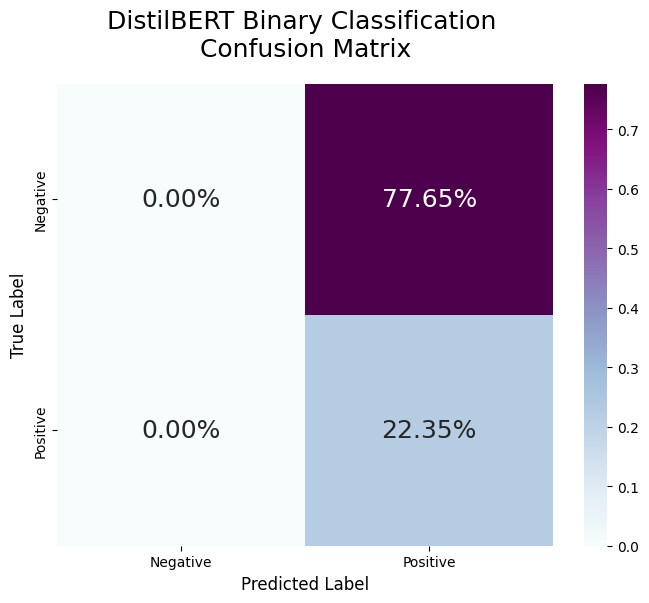

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('DistilBERT Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_Distilbert.png', transparent=True)
plt.show()

In [14]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred.flatten()}) # Use y_pred.flatten() instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
195   MLB Made Dramatic Rule Changes. These All-Star...           1   
5564  See Jason Momoa in the first trailer for 'Aqua...           1   
114   Six Exercises to Keep Shoulders Strong and Stable           1   

      predicted_label  
195                 1  
5564                1  
114                 1  

True Negatives:
Empty DataFrame
Columns: [text, true_label, predicted_label]
Index: []

False Positives:
                                                   text  true_label  \
3010  How CDC Will Track Viruses Over the Holiday Tr...           0   
4219  Sacramento police stop mother and 8-year-old s...           0   
1132  Noel Gallagher concert canceled over the weeke...           0   

      predicted_label  
3010                1  
4219                1  
1132                1  

False Negatives:


,text,true_label,predicted_label


## **6. Model 2: Convolutional Neural Network (CNN)**

We build a CNN model for text classification.

### **6.1 Defining the Model**

In [31]:
from tensorflow.keras.regularizers import l2

def create_cnn_model(vocab_size=20000, embedding_dim=100, max_length=128):
    """
    Creates and compiles a CNN model for binary classification.
    """
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post')

    # Build the CNN model

    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, X_train_seq, X_val_seq

### **6.2 Training the Model**

In [32]:
cnn_model, X_train_seq, X_val_seq = create_cnn_model()
cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.5263 - loss: 0.6880 - val_accuracy: 0.5416 - val_loss: 0.6952
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.8168 - loss: 0.4401 - val_accuracy: 0.7002 - val_loss: 0.5987
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9687 - loss: 0.1171 - val_accuracy: 0.6758 - val_loss: 0.8086
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9949 - loss: 0.0272 - val_accuracy: 0.6873 - val_loss: 0.9546
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9952 - loss: 0.0172 - val_accuracy: 0.6484 - val_loss: 1.0998


### **6.3 Testing the Model**

In [33]:

def test_cnn_model(model, X_test, y_test, vocab_size=20000, max_length=128):
    """Tests the trained CNN model and saves predictions."""
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_test)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')
    y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

    return y_pred #return y_pred

# Example usage (assuming cnn_model, X_test, and y_test are defined)
y_pred = test_cnn_model(cnn_model, X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.79      0.40      0.53      1018
           1       0.23      0.62      0.34       293

    accuracy                           0.45      1311
   macro avg       0.51      0.51      0.44      1311
weighted avg       0.66      0.45      0.49      1311



### 6.4 Confusion Matrix and Headlines examples

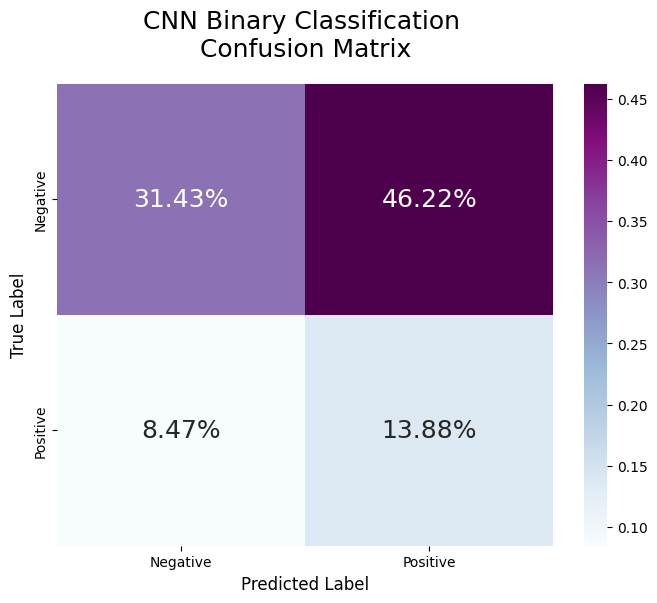

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('CNN Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_CNN.png', transparent=True)
plt.show()

In [36]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred.flatten()}) # Use y_pred.flatten() instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
195   MLB Made Dramatic Rule Changes. These All-Star...           1   
5564  See Jason Momoa in the first trailer for 'Aqua...           1   
6343  A 4-year-old went fishing with her dad. They f...           1   

      predicted_label  
195                 1  
5564                1  
6343                1  

True Negatives:
                                                   text  true_label  \
4219  Sacramento police stop mother and 8-year-old s...           0   
1132  Noel Gallagher concert canceled over the weeke...           0   
5861  Russia’s Lavrov elicits cheers and groans at I...           0   

      predicted_label  
4219                0  
1132                0  
5861                0  

False Positives:
                                                   text  true_label  \
3010  How CDC Will Track Viruses Over the Holiday Tr...           0   
5578  US and Russia fail to pass Gaza resolut

,text,true_label,predicted_label
114,Six Exercises to Keep Shoulders Strong and Stable,1,0
3619,Killers of the Flower Moon and who gets to tel...,1,0
3033,Jamie Bernstein: What Maestro Gets Right About...,1,0


## **7. Model 3: Recurrent Neural Network (RNN)**

We build an RNN model using LSTM layers.

### **7.1 Defining the Model**

In [23]:
def create_rnn_model(vocab_size=20000, embedding_dim=100, max_length=128, hidden_units=128):
    """
    Creates and compiles an RNN model with LSTM layers for binary classification.
    """
    # Build the RNN model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, name="embedding_layer"),
        LSTM(hidden_units, return_sequences=True, name="lstm_layer"),
        GlobalMaxPooling1D(name="global_max_pooling"),
        Dense(64, activation='relu', name="dense_layer"),
        Dropout(0.3, name="dropout_layer"),
        Dense(1, activation='sigmoid', name="output_layer")
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

### **7.2 Tokenization and Padding**

In [24]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=128, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=128, padding='post')

### **7.3 Training the Model**

In [25]:
rnn_model = create_rnn_model()
history = rnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    batch_size=32,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.4884 - loss: 0.6936 - val_accuracy: 0.2098 - val_loss: 0.7002
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 268ms/step - accuracy: 0.5652 - loss: 0.6904 - val_accuracy: 0.5431 - val_loss: 0.6909
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.6783 - loss: 0.6831 - val_accuracy: 0.6476 - val_loss: 0.6755
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - accuracy: 0.7441 - loss: 0.6970 - val_accuracy: 0.4683 - val_loss: 0.7038
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.7934 - loss: 0.5973 - val_accuracy: 0.6484 - val_loss: 0.6228
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.8453 - loss: 0.3968 - val_accuracy: 0.6430 - val_loss: 0.7311
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 349ms/step - accuracy: 0.9262 - loss: 0.2204 - val_accuracy: 0.6491 - val_loss: 0.8599
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 262ms/step - accuracy: 0.9571 - loss: 0.1428 - val

### **7.4 Testing the model**

In [26]:
def test_rnn_model(model, X_test, y_test, vocab_size=20000, max_length=128):
    """Tests the trained RNN model."""
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_test)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')
    y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

test_rnn_model(rnn_model, X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
              precision    recall  f1-score   support

           0       0.78      0.47      0.59      1018
           1       0.22      0.53      0.32       293

    accuracy                           0.49      1311
   macro avg       0.50      0.50      0.45      1311
weighted avg       0.65      0.49      0.53      1311



### 7.5 CM and headlines examples

In [27]:
def test_rnn_model(model, X_test, y_test, vocab_size=20000, max_length=128):
    """Tests the trained RNN model."""
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_test)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')
    y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))
    return y_pred

y_pred = test_rnn_model(rnn_model, X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
              precision    recall  f1-score   support

           0       0.78      0.47      0.59      1018
           1       0.22      0.53      0.32       293

    accuracy                           0.49      1311
   macro avg       0.50      0.50      0.45      1311
weighted avg       0.65      0.49      0.53      1311



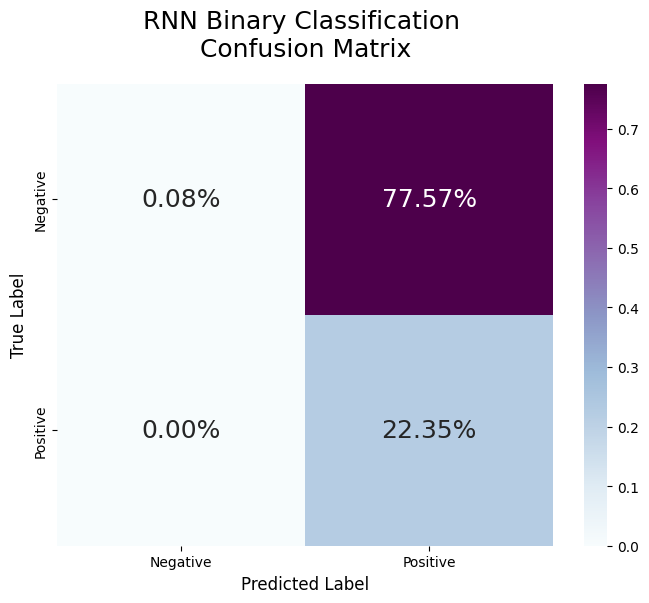

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('RNN Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_RNN.png', transparent=True)
plt.show()

In [30]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred.flatten()}) # Use y_pred.flatten() instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
195   MLB Made Dramatic Rule Changes. These All-Star...           1   
6343  A 4-year-old went fishing with her dad. They f...           1   
6079  Caroline Wozniacki vs. Petra Kvitova at U.S. O...           1   

      predicted_label  
195                 1  
6343                1  
6079                1  

True Negatives:
                                                   text  true_label  \
4219  Sacramento police stop mother and 8-year-old s...           0   
1132  Noel Gallagher concert canceled over the weeke...           0   
5861  Russia’s Lavrov elicits cheers and groans at I...           0   

      predicted_label  
4219                0  
1132                0  
5861                0  

False Positives:
                                                   text  true_label  \
3010  How CDC Will Track Viruses Over the Holiday Tr...           0   
4752  France to Ban Full-Length Muslim Robes 

,text,true_label,predicted_label
5564,See Jason Momoa in the first trailer for 'Aqua...,1,0
114,Six Exercises to Keep Shoulders Strong and Stable,1,0
3619,Killers of the Flower Moon and who gets to tel...,1,0


## **8. Model 5: RNN with Attention Mechanism**

We build an RNN model with an attention layer to capture long-range dependencies.


### **9.1 Defining the Model**

In [37]:
def create_rnn_with_attention_model(vocab_size=20000, embedding_dim=100, max_length=128, hidden_units=128):
    """
    Create an RNN model with an added Attention layer for text classification.
    """
    # Input layer
    inputs = Input(shape=(max_length,), name="input_layer")

    # Embedding layer
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length, name="embedding_layer")(inputs)

    # LSTM layer
    lstm_out = LSTM(hidden_units, return_sequences=True, name="lstm_layer")(embedding)

    # Attention layer: query and value are both the LSTM output
    attention_out = Attention(name="attention_layer")([lstm_out, lstm_out])

    # GlobalMaxPooling to reduce dimensionality
    pooled_out = GlobalMaxPooling1D(name="global_max_pooling")(attention_out)

    # Fully connected layers
    dense = Dense(64, activation='relu', name="dense_layer")(pooled_out)
    dropout = Dropout(0.3, name="dropout_layer")(dense)
    outputs = Dense(1, activation='sigmoid', name="output_layer")(dropout)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name="rnn_with_attention")

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

### **8.2 Tokenization and Padding**

In [38]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=128, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=128, padding='post')

### **8.3 Training the Model**

In [39]:
rnn_attention_model = create_rnn_with_attention_model()
history = rnn_attention_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    batch_size=64,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 718ms/step - accuracy: 0.4792 - loss: 0.6933 - val_accuracy: 0.2082 - val_loss: 0.6959
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 644ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.2082 - val_loss: 0.6972
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.4963 - loss: 0.6932 - val_accuracy: 0.2082 - val_loss: 0.6964
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step - accuracy: 0.5036 - loss: 0.6931 - val_accuracy: 0.7857 - val_loss: 0.6927
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.5182 - loss: 0.6927 - val_accuracy: 0.2082 - val_loss: 0.6970
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.5128 - loss: 0.6930 - val_accuracy: 0.2082 - val_loss: 0.6967
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 765ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.2593 - val_loss: 0.6938
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 454ms/step - accuracy: 0.5067 - loss: 0.6928 - val_accuracy: 0.209

### **8.4 Testing the Model**

In [40]:
def test_rnn_attention_model(model, X_test, y_test, vocab_size=20000, max_length=128):
    """Tests the trained RNN with attention model."""
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_test)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')
    y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))
    return y_pred

y_pred = test_rnn_attention_model(rnn_attention_model, X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1018
           1       0.22      1.00      0.37       293

    accuracy                           0.22      1311
   macro avg       0.61      0.50      0.18      1311
weighted avg       0.83      0.22      0.08      1311



### 8.5 CM and headlines examples

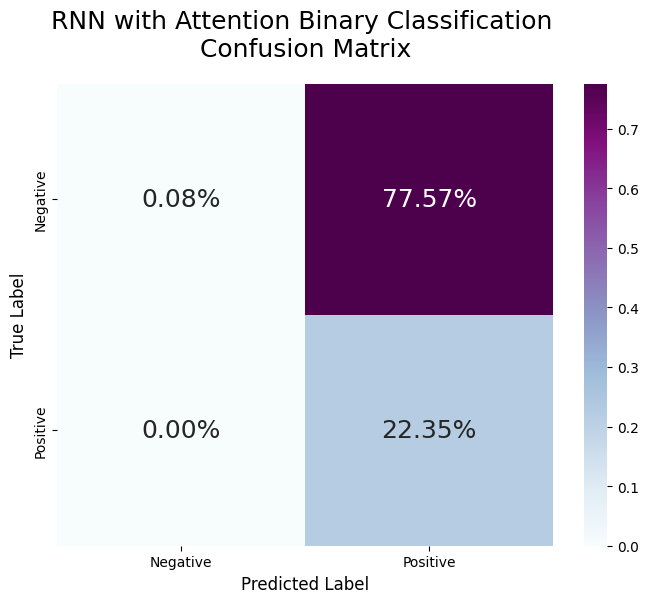

In [43]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('RNN with Attention Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_RNN+attention.png', transparent=True)
plt.show()

In [45]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred.flatten()}) # Use y_pred.flatten() instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
195   MLB Made Dramatic Rule Changes. These All-Star...           1   
5564  See Jason Momoa in the first trailer for 'Aqua...           1   
114   Six Exercises to Keep Shoulders Strong and Stable           1   

      predicted_label  
195                 1  
5564                1  
114                 1  

True Negatives:
                                                   text  true_label  \
3153  A would-be thief gave up on his attempt and on...           0   

      predicted_label  
3153                0  

False Positives:
                                                   text  true_label  \
3010  How CDC Will Track Viruses Over the Holiday Tr...           0   
4219  Sacramento police stop mother and 8-year-old s...           0   
1132  Noel Gallagher concert canceled over the weeke...           0   

      predicted_label  
3010                1  
4219                1  
1132                

,text,true_label,predicted_label


## **9. BERT + CNN**
This model is on the next notebook, 03b
